$$\mathbb{E}_{q(z|x, \phi)} p(y|x, \theta)$$

$$u \sim \text{Uniform}(0, 1)$$
$$g = -\text{log}(-\text{log}(u))$$
$$z = \frac{\theta + g}{\tau}$$

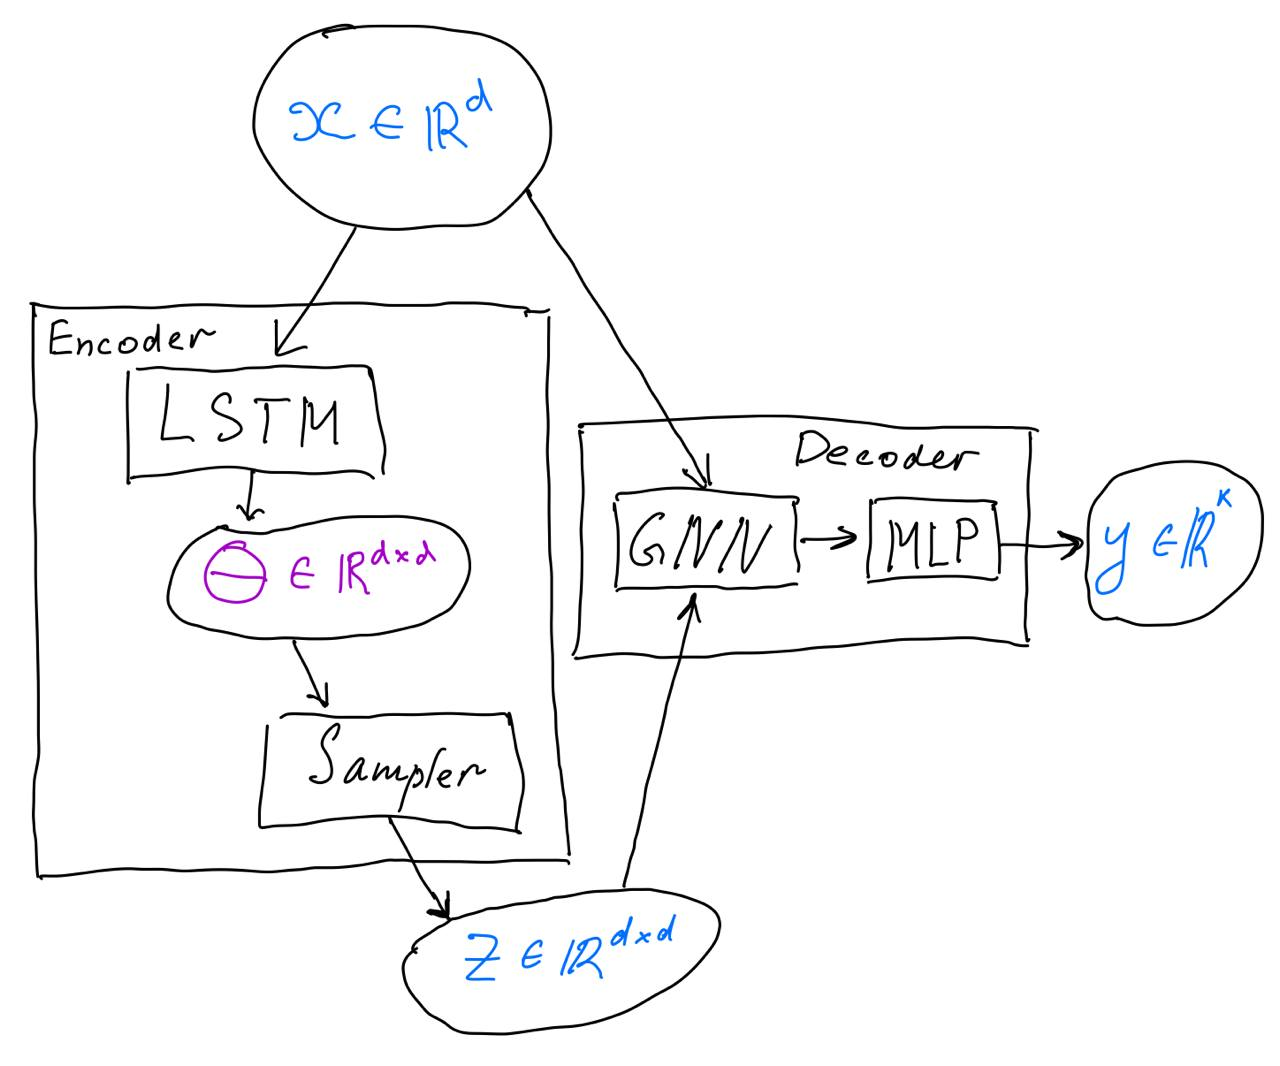

In [1]:
!git clone https://github.com/agadetsky/sochischool.git

Cloning into 'sochischool'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 266 (delta 13), reused 19 (delta 8), pack-reused 231
Receiving objects: 100% (266/266), 50.76 MiB | 26.59 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Checking out files: 100% (195/195), done.


In [2]:
!pip install -qU git+https://github.com/harvardnlp/pytorch-struct

In [3]:
import random
import sys
sys.path.append('/content/sochischool/')

In [4]:
import torch
import numpy as np
from torch_struct import DependencyCRF
from tqdm import tqdm

In [5]:
import listops.data as _data
import listops.model as _model
from listops.school_utils import compute_metrics
from listops.model_modules.sampler import DependencySampler, BinaryIndependentSampler

In [6]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [7]:
%%capture

datasets = _data.get_datasets(
    "var_5_50_nosm_20000",
    datadirpath="/content/sochischool/listops/data_processing/python/listops/data"
  )

In [8]:
%%capture

train_loader, val_loader, test_loader  = _data.get_dataloaders(datasets, batchsize=50)

In [9]:
class ProjectiveSampler(DependencySampler):

    def __init__(self, noise, tau):
        assert noise in set(['gumbel', 'gaussian'])
        super(ProjectiveSampler, self).__init__("soft", noise, tau, True, False)
        
    def inject_noise(self, A):
        if self.noise == "gumbel":
            u = torch.distributions.utils.clamp_probs(torch.rand_like(A))
            noise = u.log().neg().log().neg()
            return (A + noise) / self.tau
        elif self.noise == "gaussian":
            noise = torch.randn_like(A)
            return (A + noise) / self.tau

    def sample(self, A, lengths, mode):
        if mode == "soft":
            return DependencyCRF(self.inject_noise(A), lengths).marginals
        elif mode == "hard":
            return DependencyCRF(self.inject_noise(A), lengths).argmax.detach()

In [10]:
class BinarySampler(BinaryIndependentSampler):

    def __init__(self, noise, tau):
        assert noise in set(['logistic'])
        super(BinarySampler, self).__init__("soft", noise, tau)

    def inject_noise(self, A):
        if self.noise == "logistic":
            u = torch.distributions.utils.clamp_probs(torch.rand_like(A))
            noise = u.log() - u.neg().log1p()
            return (A + noise) / self.tau

    def sample(self, A, lengths, mode):
        if mode == "soft":
            return self.inject_noise(A).sigmoid()
        elif mode == "hard":
            return (self.inject_noise(A.detach()) > 0.0).float()

In [11]:
def training(m, train_loader, opt, num_epochs):
    m.train()
    for _ in range(num_epochs):
        for batch_idx, (x, y, arcs, lengths, depths) in enumerate(tqdm(train_loader)):
            opt.zero_grad()

            x = x.cuda()
            y = y.cuda()
            arcs = arcs.cuda()
            lengths = lengths.cuda()
            
            with torch.set_grad_enabled(True):
                pred_logits = m(x, arcs, lengths)
                loss = torch.nn.functional.cross_entropy(pred_logits, y)
                loss.backward()
                opt.step()

In [12]:
def validation(m, val_loader):
    m.eval()
    val_losses = []
    val_accs = []
    val_precs = []
    val_recs = []
    for batch_idx, (x, y, arcs, lengths, depths) in enumerate(tqdm(val_loader)):
        x = x.cuda()
        y = y.cuda()
        arcs = arcs.cuda()
        lengths = lengths.cuda()
        with torch.no_grad():
          pred_logits = m(x, arcs, lengths)
          loss = torch.nn.functional.cross_entropy(pred_logits, y)
          acc = (pred_logits.argmax(-1) == y).float().mean()
          precision, recall = (compute_metrics(m.sample, arcs, lengths))

        val_losses.append(loss.item())
        val_accs.append(acc.item())
        val_precs.append(precision.item())
        val_recs.append(recall.item())
    return val_losses, val_accs, val_precs, val_recs

In [13]:
sampler = BinarySampler("logistic", 1.0)
m = _model.get_school_model(sampler)
m.cuda()
opt = torch.optim.AdamW(m.parameters())
training(m, train_loader, opt, num_epochs=2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
100%|██████████| 2000/2000 [02:56<00:00, 11.33it/s]


In [14]:
val_losses, val_accs, val_precs, val_recs = validation(m, val_loader)

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


In [15]:
np.mean(val_losses)

0.530943063646555

In [16]:
np.mean(val_accs)

0.8084000408649444

In [17]:
np.mean(val_precs)

0.10717825219035149

In [18]:
np.mean(val_recs)

0.40346491038799287

In [19]:
sampler = ProjectiveSampler("gumbel", 1.0)
m = _model.get_school_model(sampler)
m.cuda()
opt = torch.optim.AdamW(m.parameters())
training(m, train_loader, opt, num_epochs=2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
100%|██████████| 2000/2000 [12:03<00:00,  2.77it/s]


In [20]:
val_losses, val_accs, val_precs, val_recs = validation(m, val_loader)

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [21]:
np.mean(val_losses)

0.7142713025212288

In [22]:
np.mean(val_accs)

0.7508000373840332

In [23]:
np.mean(val_precs)

0.6151826977729797

In [24]:
np.mean(val_recs)

0.6151826977729797